In [10]:
from data_formats import read_data
from dose_reponse_fit import dose_response_fit, StandardSettings
import matplotlib.pyplot as plt
from plotting import *
from stress_survival_conversion import stress_to_survival, survival_to_stress
import random
import glob
from tqdm import tqdm
import torch

import sympy
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [11]:
files = []

for i in glob.glob("data/*.xlsx"):
    data = read_data(i)

    if data.meta.chemical in ["Clothianidin", "Esfenvalerate", "BPS"]:
        files.append(data)


fits = []
for data in files:
    data: ExperimentData
    for stressor in data.additional_stress:
        settings = StandardSettings(survival_max=data.meta.max_survival, len_curves=100)

        main_fit = dose_response_fit(data.main_series, settings)

        stress_fit = dose_response_fit(data.additional_stress[stressor], settings)

        fits.append((data, stressor, main_fit, stress_fit))

In [12]:
x1s, x2s, ys = [], [], []

for data, stressor, main_fit, stress_fit in fits:
    main_fit: ModelPredictions
    stress_fit: ModelPredictions

    x1s.append(main_fit.survival_curve / data.meta.max_survival)
    x2s.append(np.ones_like(main_fit.survival_curve) * stress_fit.optim_param["d"])

    ys.append(stress_fit.survival_curve / data.meta.max_survival)

X = np.stack((np.concatenate(x1s), np.concatenate(x2s)), axis=1)
y = np.concatenate(ys)
X.min(), X.max(), y.min(), y.max(), X.shape, y.shape

(0.00017854014846201174,
 1.0,
 8.131654070597656e-07,
 0.9999999083260045,
 (3700, 2),
 (3700,))

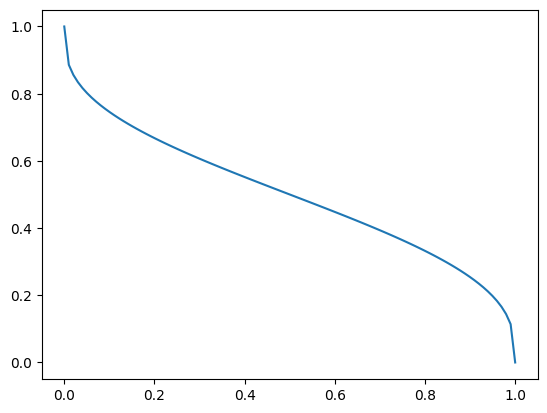

In [13]:
x = np.linspace(0, 1, 100)
plt.plot(x, survival_to_stress(x))

In [38]:
import torch

# Assuming X and y are your data, and using the sigmoid functions you provided
surv = torch.tensor(X[:, 0], dtype=torch.float32, requires_grad=True)
stress = torch.tensor(y, dtype=torch.float32, requires_grad=True)

# Learnable parameters for the sigmoid transformation
learnable_a = torch.randn((), requires_grad=True)  # Single scalar parameter
learnable_b = torch.randn((), requires_grad=True)  # Single scalar parameter


# Sigmoid function for survival to stress transformation
def survival_to_stress_sigmoid(survival, a, b):
    return 1 / (1 + torch.exp(-a * (survival - b)))


# Loss function to enforce linear difference
def loss_function(surv, stress, a, b):
    surv_stress = survival_to_stress_sigmoid(surv, a, b)
    stress_stress = survival_to_stress_sigmoid(stress, a, b)

    # Calculate the differences between the transformed survival and stress
    diff = stress_stress - surv_stress

    # Minimize the variance (or standard deviation) of the differences to make them linear
    loss = torch.var(diff)  # Variance as a measure of non-linearity
    return loss


# Optimizer setup (e.g., Adam optimizer)
optimizer = torch.optim.Adam([learnable_a, learnable_b], lr=0.001)

# Training loop
epochs = 3000
for epoch in range(epochs):
    # Zero gradients
    optimizer.zero_grad()

    # Compute the loss
    loss = loss_function(surv, stress, learnable_a, learnable_b)

    # Backpropagate and update parameters
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}: Loss = {loss.item()}, a = {learnable_a.item()}, b = {learnable_b.item()}"
        )

# After training, learnable_a and learnable_b should result in a more linear difference between survival and stress

Epoch 0: Loss = 0.0013069123961031437, a = 0.9875153303146362, b = -0.22790981829166412
Epoch 100: Loss = 0.00105381035245955, a = 0.8896763324737549, b = -0.32282644510269165
Epoch 200: Loss = 0.000853654695674777, a = 0.7964472770690918, b = -0.4032977819442749
Epoch 300: Loss = 0.0006883588503114879, a = 0.7060180306434631, b = -0.4685227870941162
Epoch 400: Loss = 0.0005460083484649658, a = 0.6173384189605713, b = -0.5184991955757141
Epoch 500: Loss = 0.0004205741861369461, a = 0.5304765105247498, b = -0.5540188550949097
Epoch 600: Loss = 0.00031084674992598593, a = 0.44658395648002625, b = -0.5769994258880615
Epoch 700: Loss = 0.00021849216136615723, a = 0.3675514757633209, b = -0.5903384685516357
Epoch 800: Loss = 0.00014536079834215343, a = 0.29541635513305664, b = -0.5972326397895813
Epoch 900: Loss = 9.143203351413831e-05, a = 0.23178845643997192, b = -0.6004021167755127
Epoch 1000: Loss = 5.44274334970396e-05, a = 0.17753009498119354, b = -0.601702094078064
Epoch 1100: Loss =

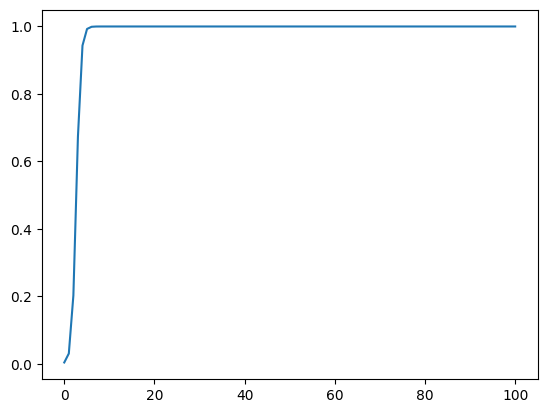

In [31]:
x = np.linspace(0, 100, 100)
plt.plot(
    x,
    survival_to_stress_sigmoid(torch.tensor(x), learnable_a, learnable_b)
    .detach()
    .numpy(),
)

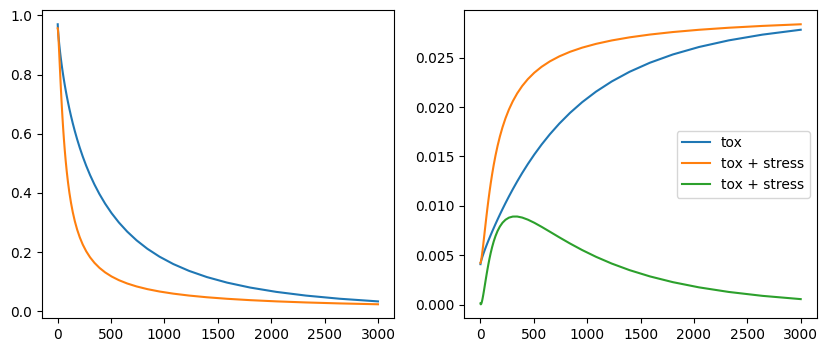

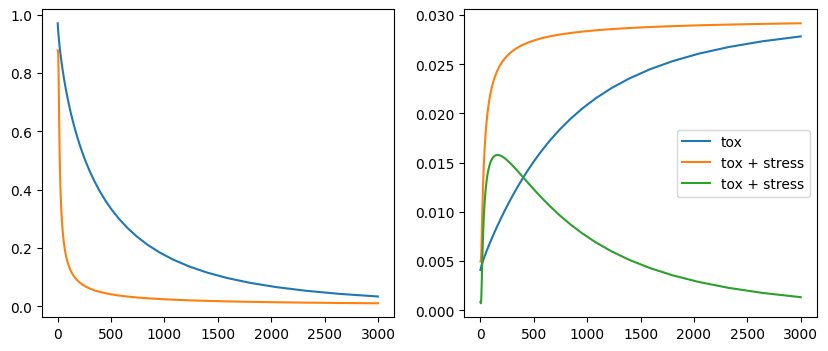

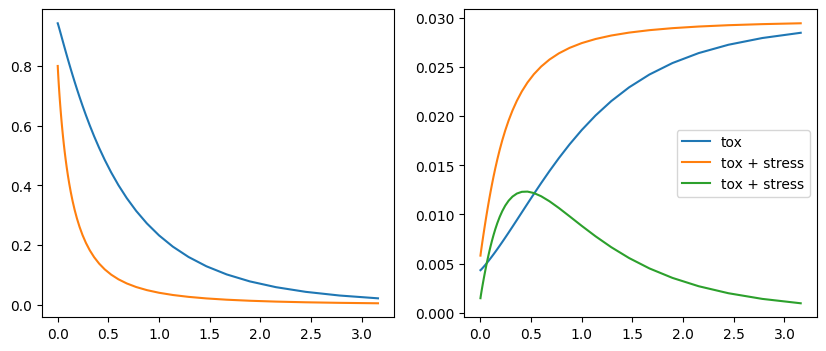

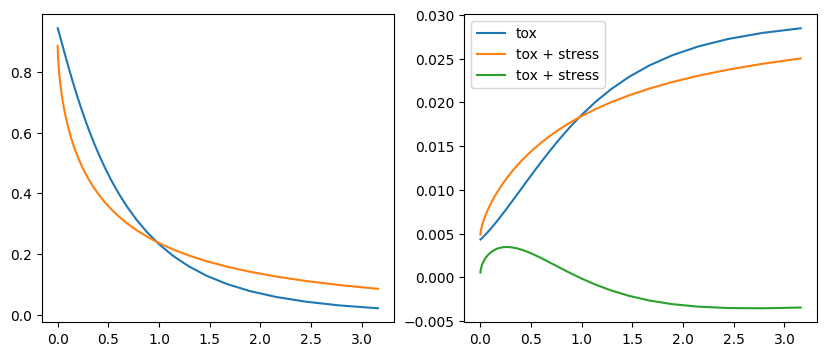

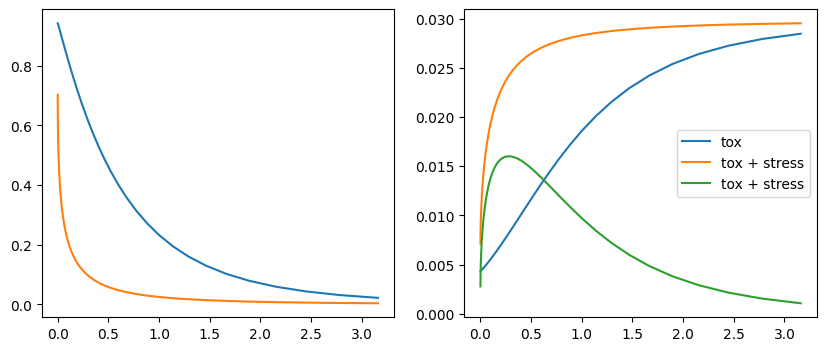

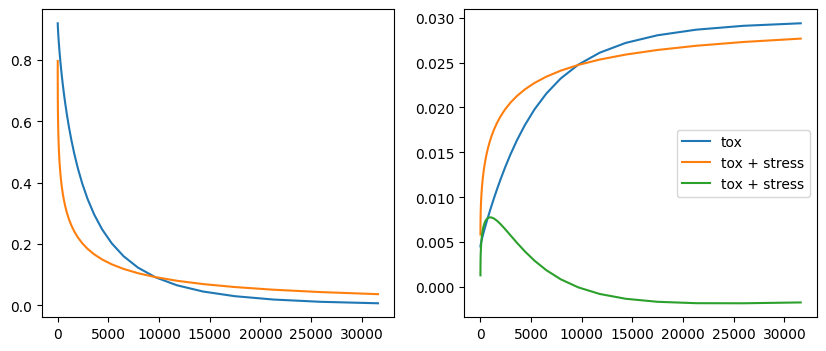

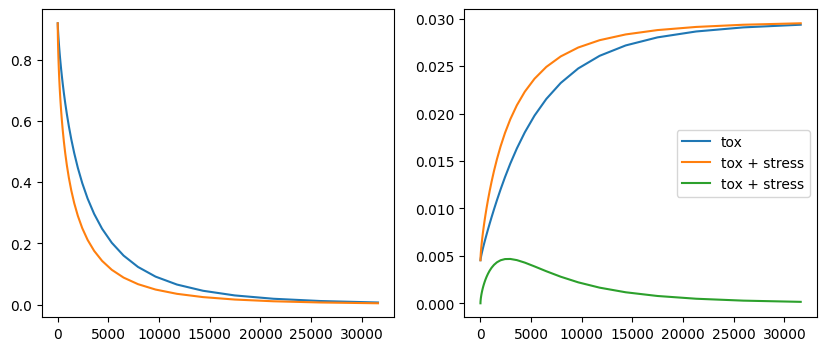

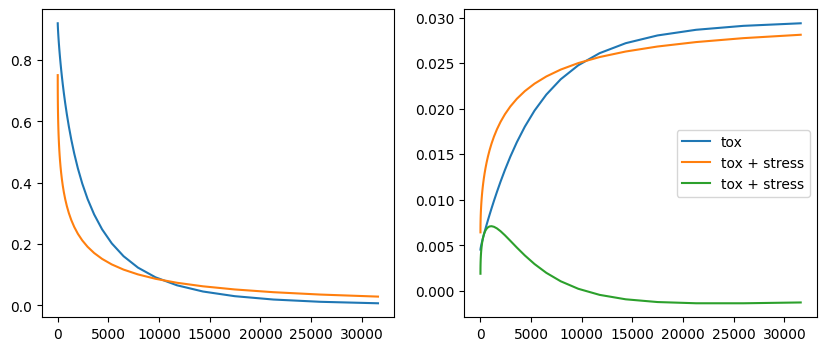

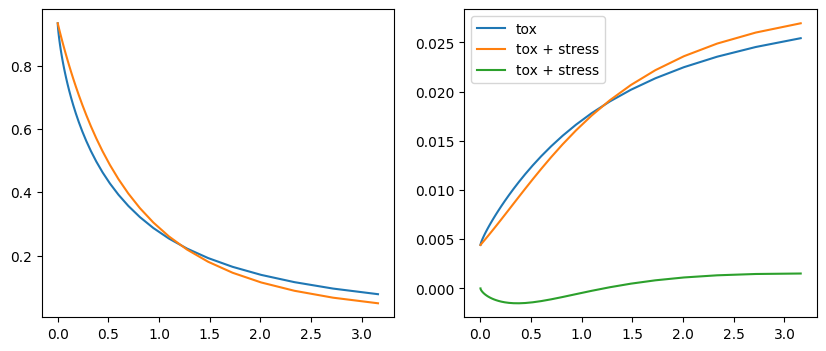

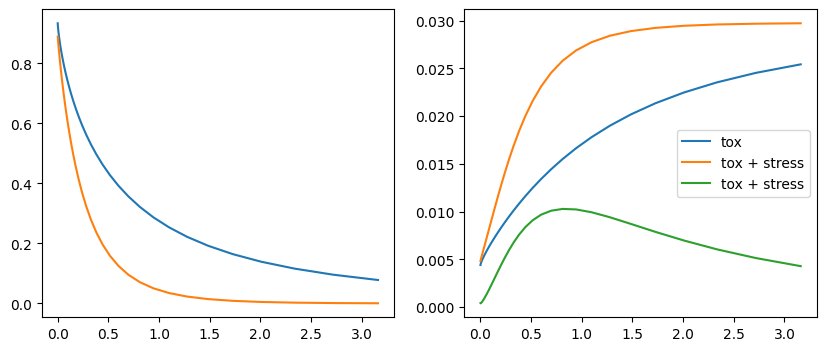

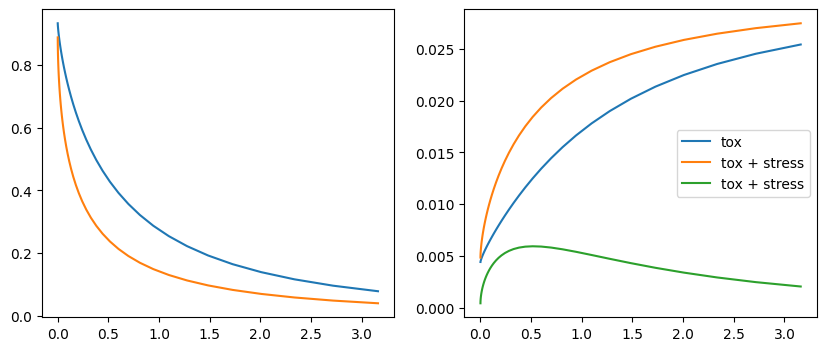

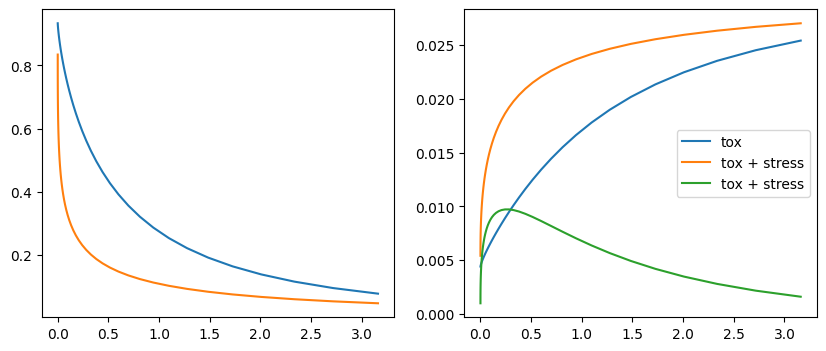

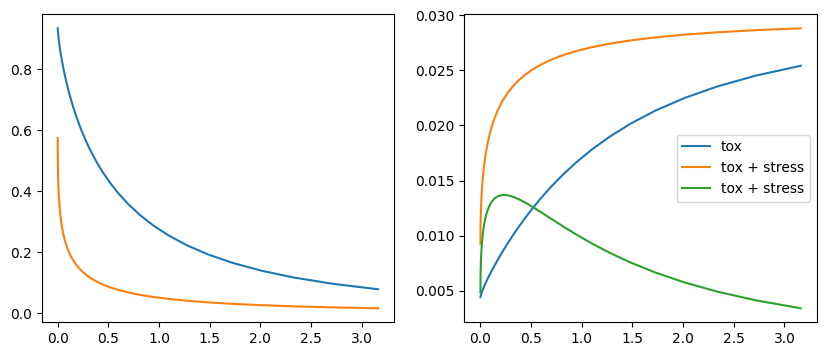

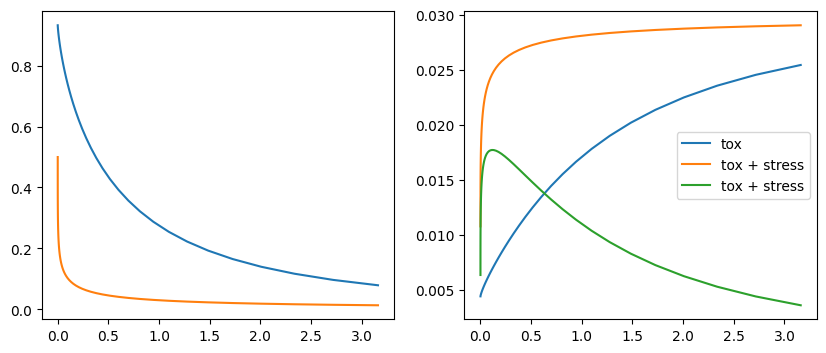

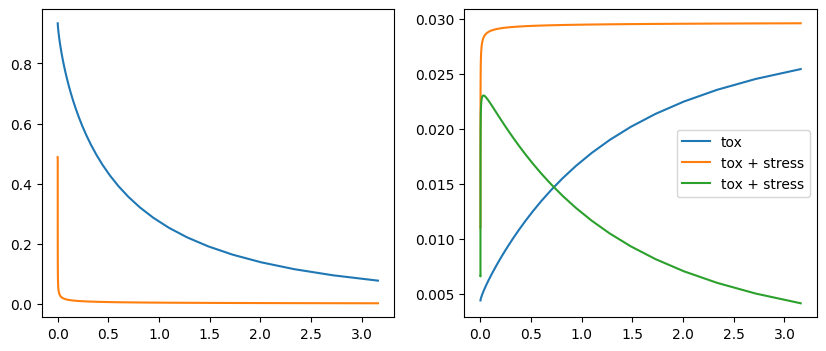

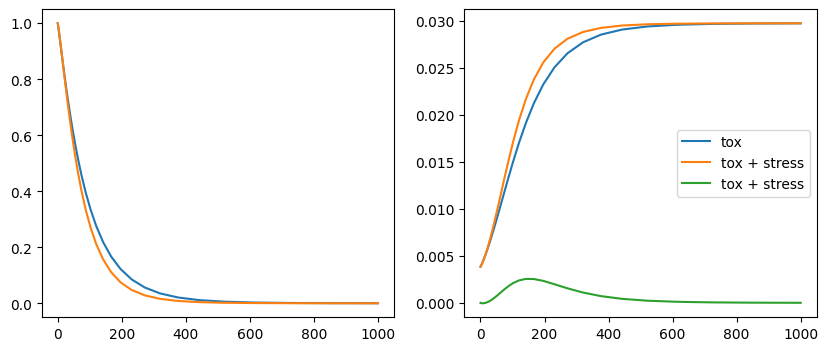

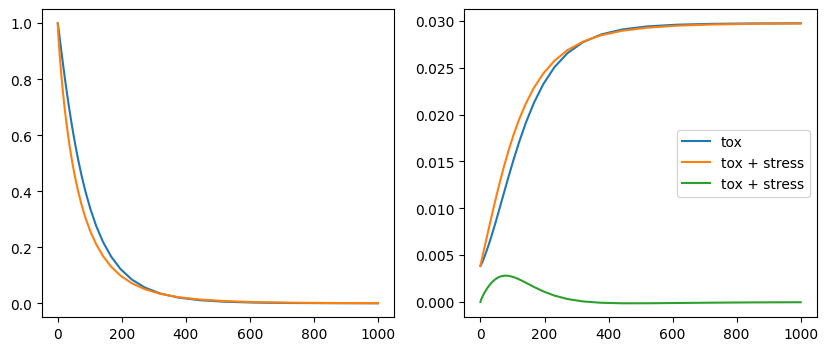

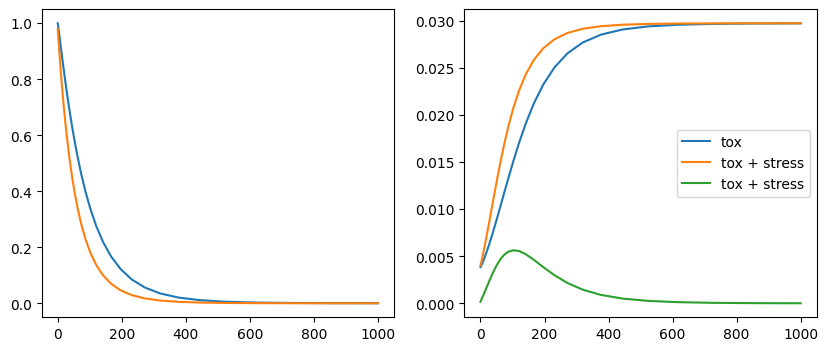

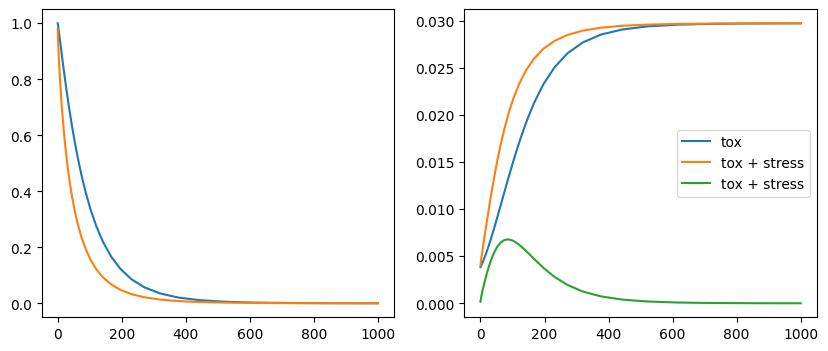

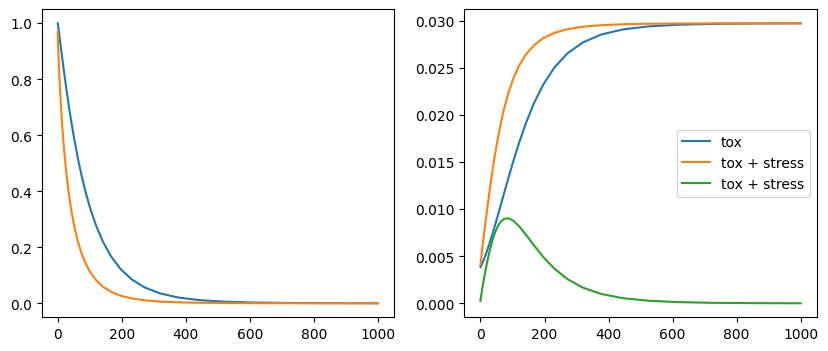

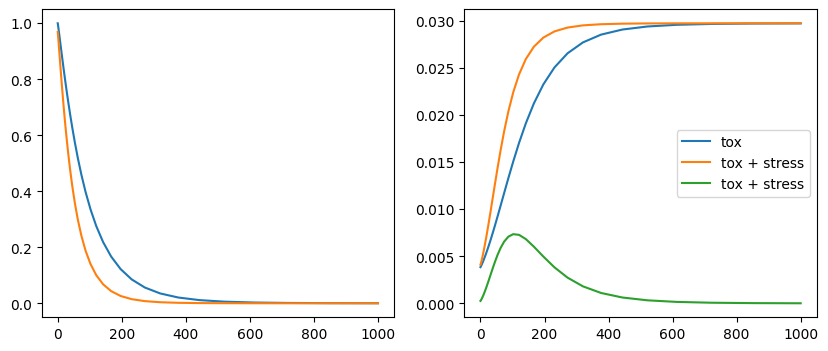

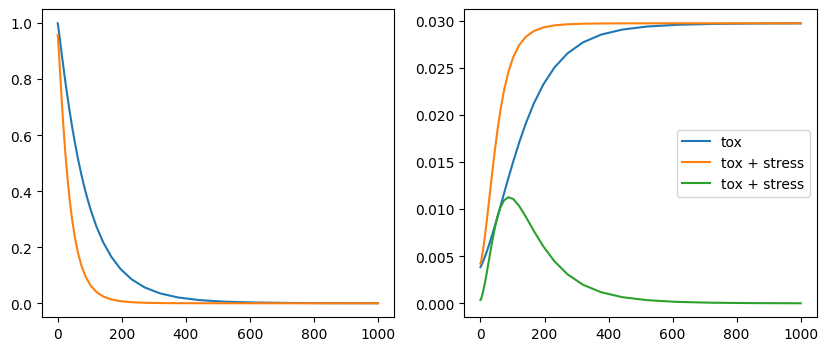

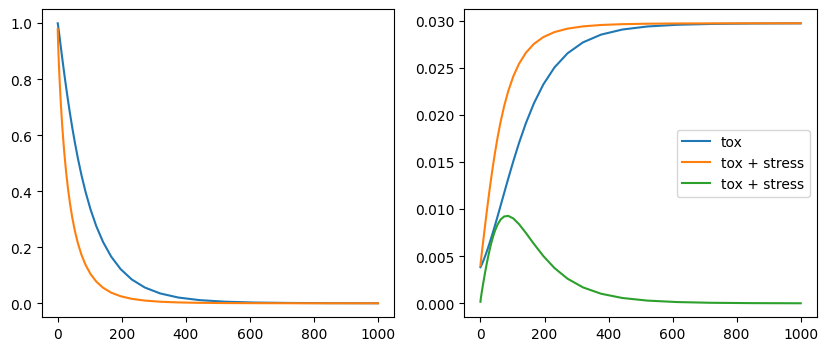

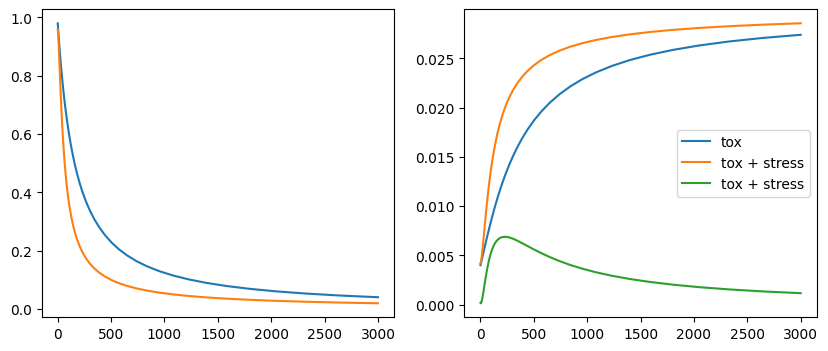

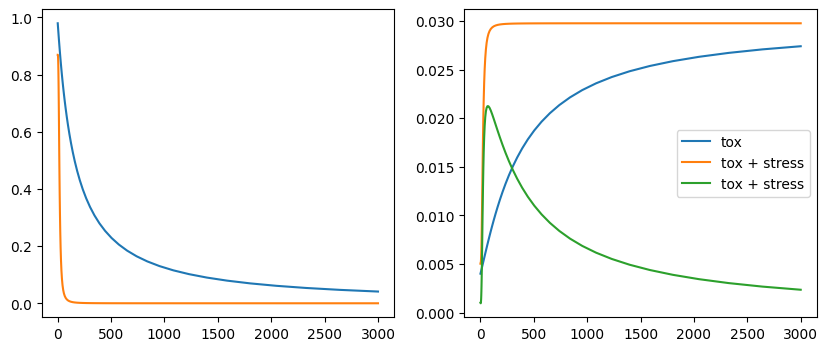

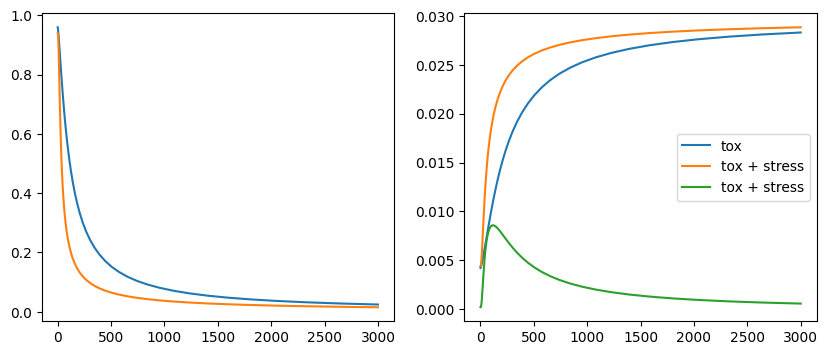

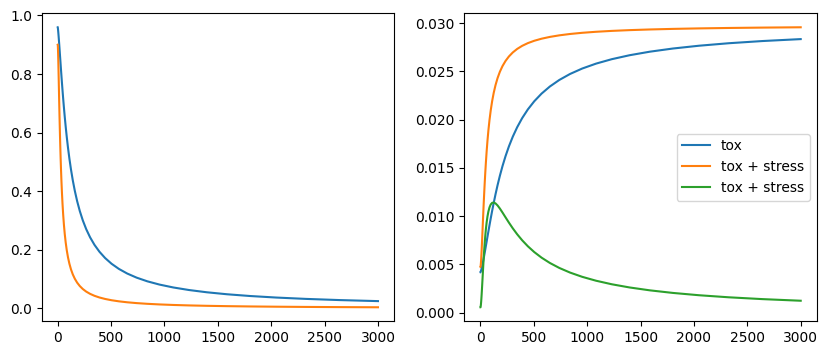

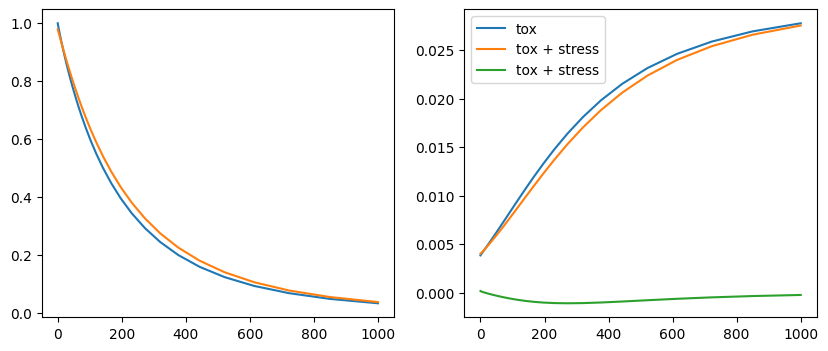

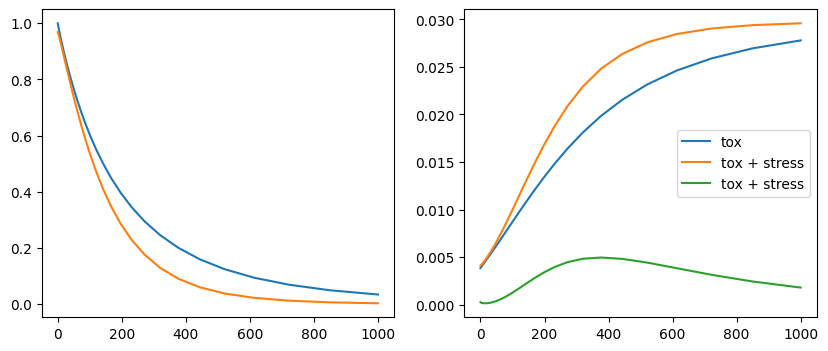

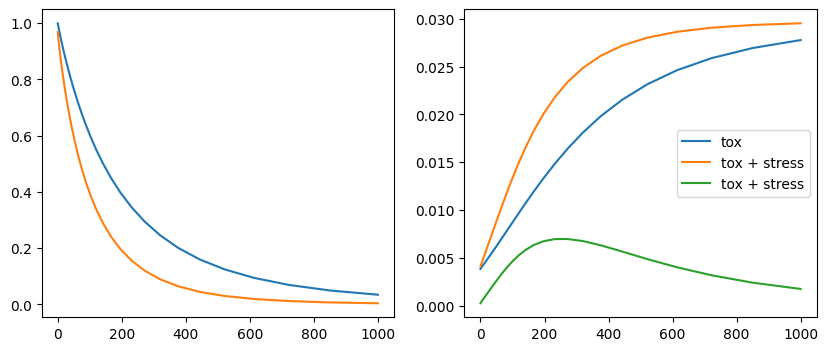

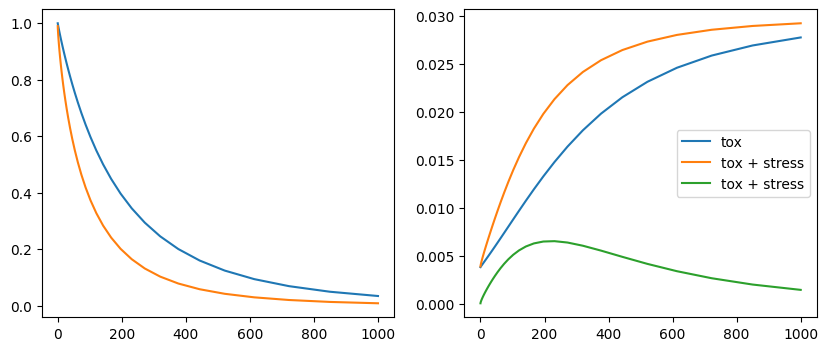

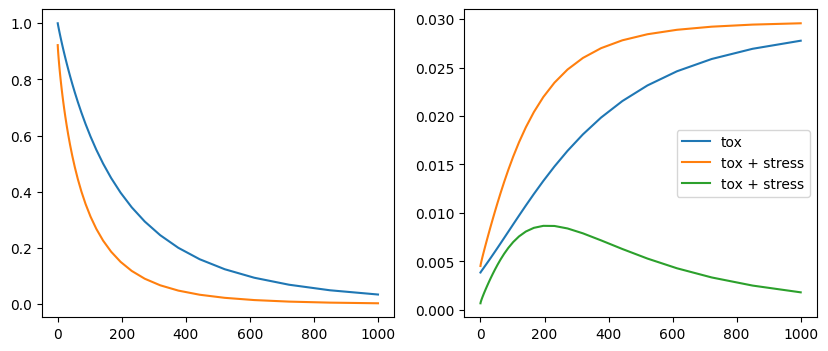

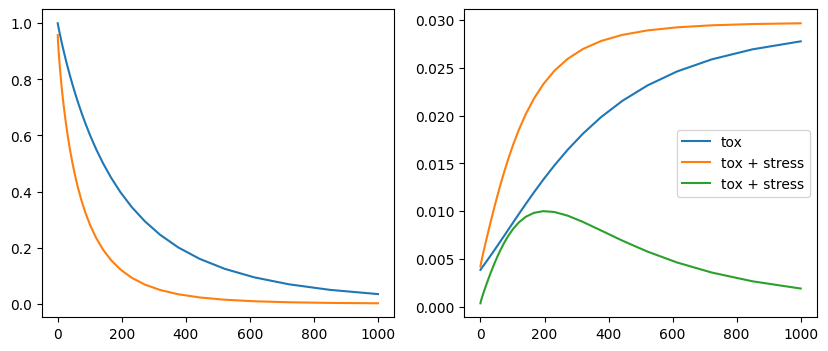

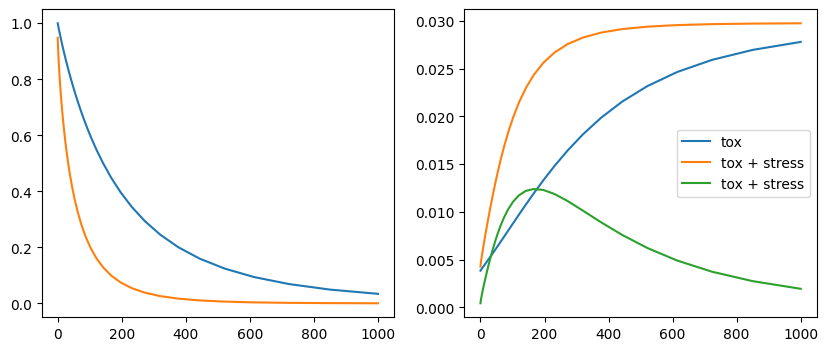

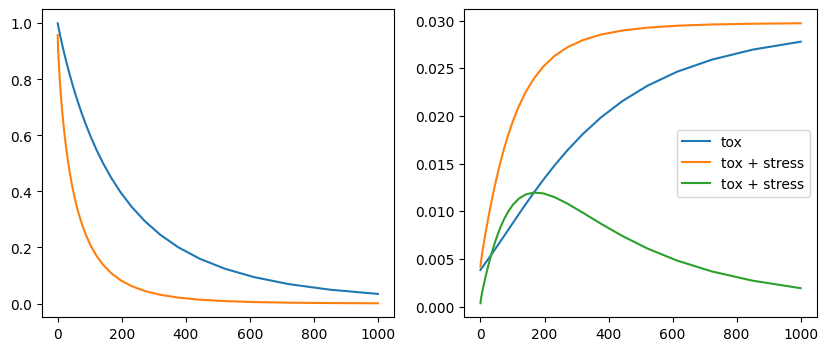

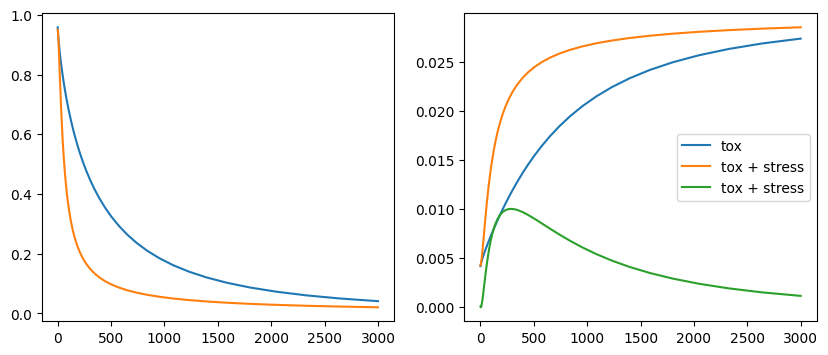

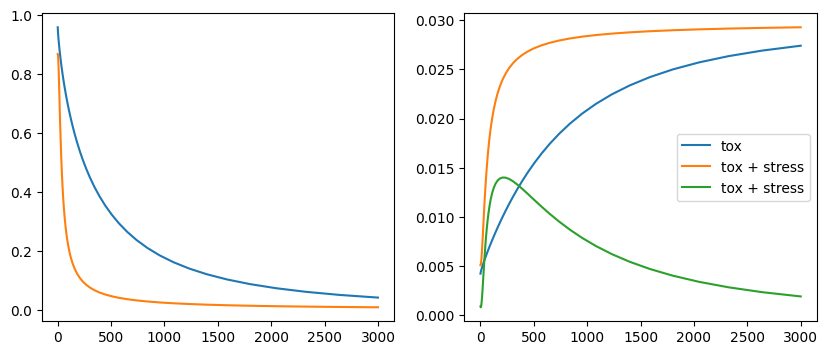

In [37]:
def to_stres(x):
    return (
        survival_to_stress_sigmoid(torch.tensor(1 - x), learnable_a, learnable_b)
        .detach()
        .numpy()
    )


for data, stressor, main_fit, stress_fit in fits:
    surv = main_fit.survival_curve / data.meta.max_survival
    surv_stress = stress_fit.survival_curve / data.meta.max_survival

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(main_fit.concentration_curve, surv, label="tox")
    plt.plot(main_fit.concentration_curve, surv_stress, label="tox + stress")

    plt.subplot(1, 2, 2)
    a = to_stres(surv)
    b = to_stres(surv_stress)
    diff = b - a

    plt.plot(main_fit.concentration_curve, a, label="tox")
    plt.plot(main_fit.concentration_curve, b, label="tox + stress")
    plt.plot(main_fit.concentration_curve, diff, label="tox + stress")

    plt.legend()
    plt.show()